<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/ilias/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fetal ECG Seperation**
## A project for the class of **Electronic Measurements** (DUTH ECE: 8th Semester 2024-2025)

## - Κοκοροτσίκου Αγνή Ιωάννα / Kokorotsikou Agni Ioanna (58767)
## - Ξανθόπουλος Ηλίας / Xanthopoulos Ilias (58545)

## **Part 0**: Set-Up

1) Mount Google drive and load dataset. (Change data_dir to match your dataset directory).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import zipfile

# # ------ Agni's Directory ------
# data_dir = '/content/drive/MyDrive/ColabNotebooks/Fetal_ECG_Separation'
# # ------------------------------

# ------ Ilias' Directory ------
data_dir = '/content/drive/MyDrive/Fetal_ECG_Separation'
# ------------------------------

database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


2) Install and import libraries.

In [3]:
!pip install wfdb
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 72.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2744226 sha256=cdeba752ff32ed36261a2117

In [4]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, spectrogram, stft, find_peaks
from scipy.fftpack import fft, fftfreq
from scipy.fft import rfft, rfftfreq, irfft
from sklearn.decomposition import FastICA
import pyedflib
import seaborn as sns
import os
import zipfile

## **Part 1**: Signal Extraction

1) Read .edf file of choice, extract saved signals and print useful data information. Seperate ground truth signal ('Direct_1') from the abdomen signals and save QRS types and timestamps of ground truth.

In [5]:
# Input EDF file name
# ----------------------
rec = 'r01'
# ----------------------

file_path = f'/content/abdominal-and-direct-fetal-ecg-database-1.0.0/{rec}.edf'
edf_file = pyedflib.EdfReader(file_path)

signal_num = edf_file.signals_in_file
signal_labels = edf_file.getSignalLabels()
fs = edf_file.getSampleFrequency(0)  # Fs: Sampling Frequency

signals_list = [edf_file.readSignal(i) for i in range(signal_num)]
signals = np.array(signals_list)

print(f"There are {signal_num} signals/channels in edf file.")
print("Signal Labels:", signal_labels)
print(f"Sampling frequency fs: {fs}Hz")
print("(Num of channels, Num of samples over time) = ", signals.shape)

edf_file._close()

ground_truth = signals[0,:]
abdomen_signals = signals[1:,:]

qrs_annotations = wfdb.rdann(file_path, "qrs")

qrs_peaks = np.array(qrs_annotations.sample)
qrs_symbols = np.array(qrs_annotations.symbol)

There are 5 signals/channels in edf file.
Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency fs: 1000.0Hz
(Num of channels, Num of samples over time) =  (5, 300000)


2) Plot extracted signals over a specified amount of time. For the ground truth, plot the peaks of QRS complex according to saved timestamps as well.

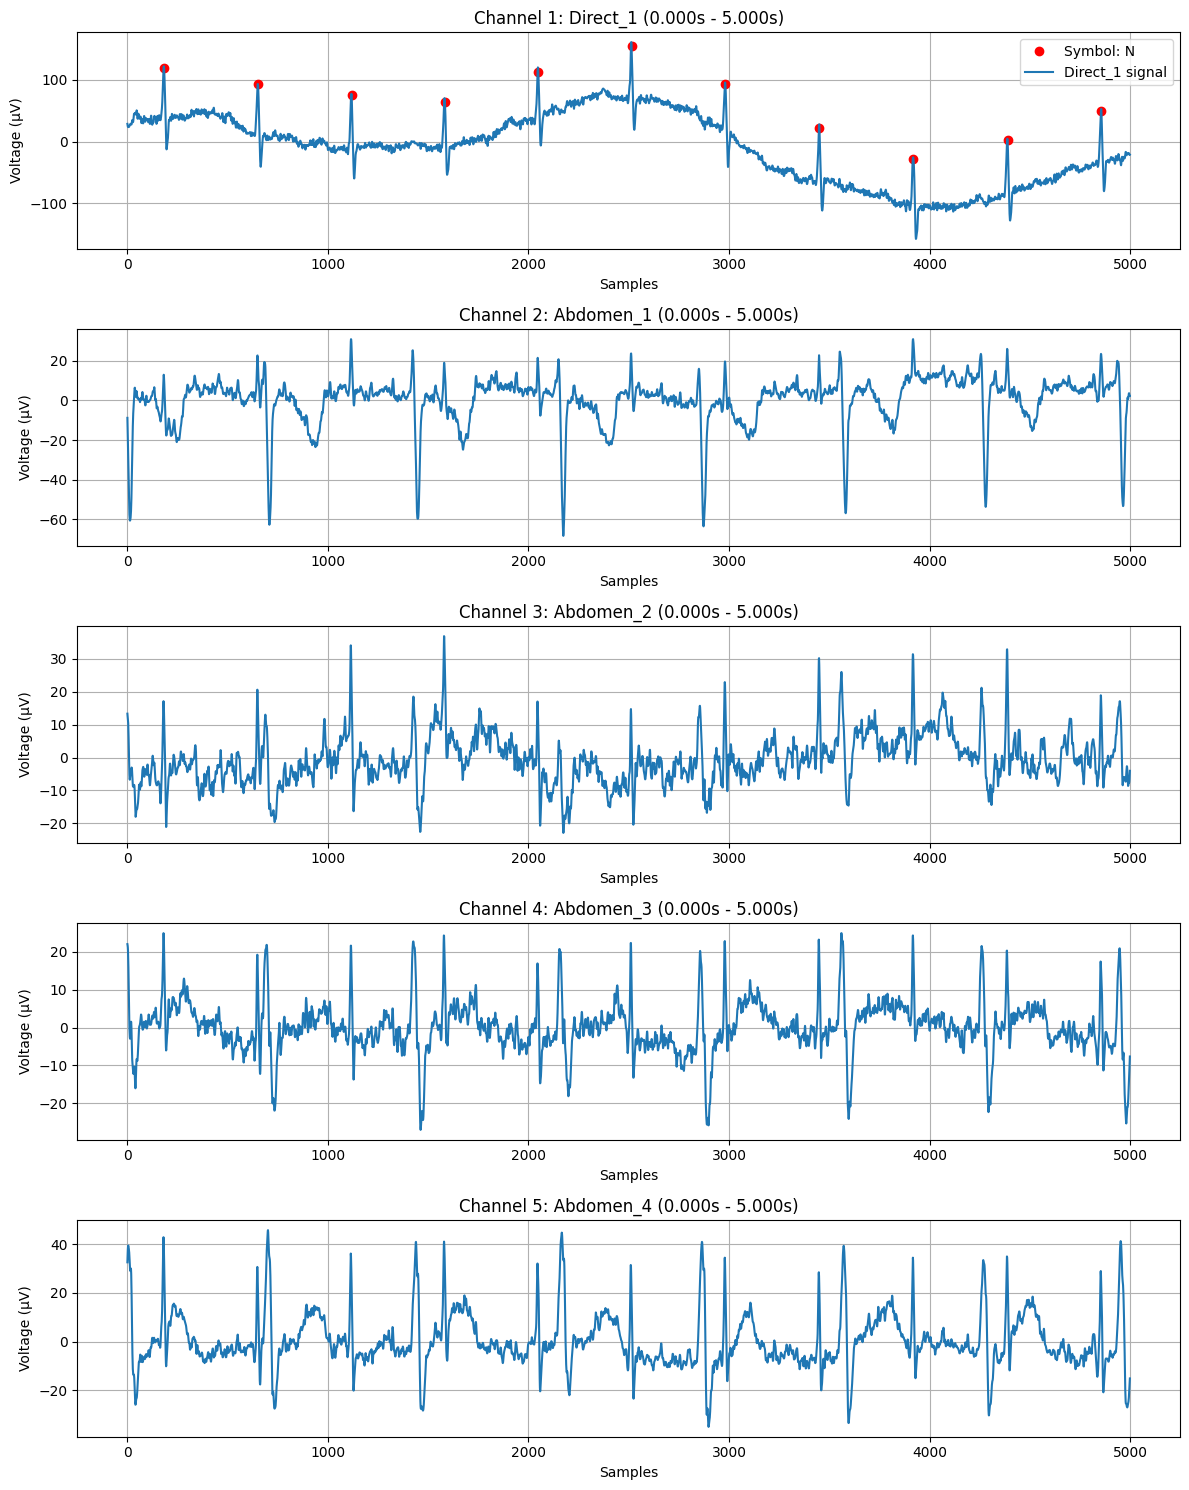

In [6]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 5      # Each signal lasts 300sec.
# ----------------------

# ex. For duration = 300 sec, 300 * fs = 300 * 1000 = 300000 samples.
start_samp = start_time * fs
fin_samp = (start_time + duration) * fs

start_samp = int(np.clip(start_samp, 0, 300 * fs))
fin_samp = int(np.clip(fin_samp, 0, 300 * fs))

symbol_colors = {
    'N': 'r',  # Normal beat - red
    'V': 'g',  # Ventricular - green
    'A': 'yellow',  # Atrial - yellow
    'L': 'orange',  # LBBB - orange
    'R': 'purple',  # RBBB - purple

    '': 'k'   # Unspecified - black
}

cropped_signals = signals[:, start_samp:fin_samp]
cropped_qrs = qrs_peaks[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]
cropped_sym = qrs_symbols[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]
channel_num = cropped_signals.shape[0]

plt.figure(figsize=(12, 3 * channel_num))

for symbol in np.unique(cropped_sym):
    color = symbol_colors.get(symbol, 'gray')  # default to gray if unknown
    sym_samples = cropped_qrs[cropped_sym == symbol] - start_samp
    plt.subplot(channel_num, 1, 1)
    plt.plot(sym_samples, cropped_signals[0,sym_samples], 'o', color=color,
             label=f'Symbol: {symbol}')

plt.plot(cropped_signals[0,:], label='Direct_1 signal')
plt.title(f'Channel {1}: {signal_labels[0]} ({start_time:.3f}s - {start_time + duration:.3f}s)')
plt.xlabel('Samples')
plt.ylabel('Voltage (μV)')
plt.legend()
plt.grid()

for i in range(1, channel_num):
    plt.subplot(channel_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'Channel {i+1}: {signal_labels[i]} ({start_time:.3f}s - {start_time + duration:.3f}s)')
    plt.xlabel('Samples')
    plt.ylabel('Voltage (μV)')
    plt.grid()

plt.tight_layout()
plt.show()

3) Calculate RR Intervals and instantaneous Heart Rate over time. For the instantaneous Heart Rate, plot over a specified time window.

RR Intervals (samples) for first 10 samples: [468 467 465 466 465 468 469 469 469 468]
RR Intervals (seconds) for first 10 samples: [0.468 0.467 0.465 0.466 0.465 0.468 0.469 0.469 0.469 0.468]
Minimum RR Interval (seconds): 0.4

Instantaneous Heart Rates (Hz) for first 10 samples: [2.137 2.141 2.151 2.146 2.151 2.137 2.132 2.132 2.132 2.137]
Instantaneous Heart Rates (bpm) for first 10 samples: [128.205 128.48  129.032 128.755 129.032 128.205 127.932 127.932 127.932
 128.205]
Max instantaneous Heart Rate (Hz): 2.5



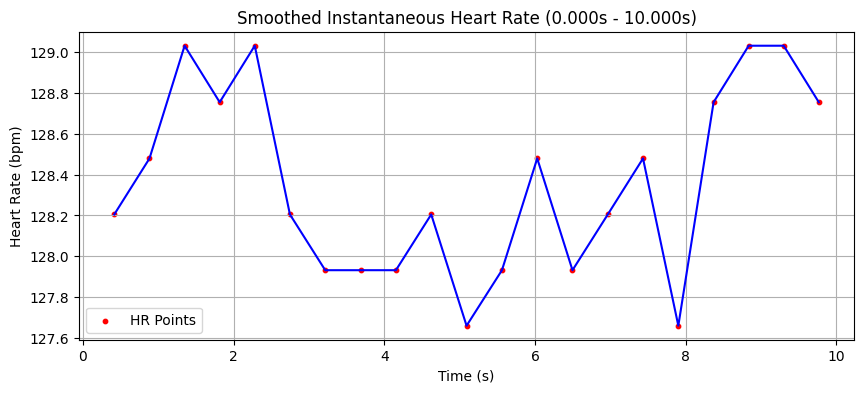

In [7]:
# Input start time and duration (in seconds) for Heart Rate plot.
# ----------------------
start_time = 0
duration = 10      # Signal lasts 300sec.
# ----------------------

end_time = start_time + duration

start_time = np.clip(start_time, 0, 300)
end_time = np.clip(end_time, 0, 300)

rr_intervals = np.diff(qrs_peaks)
print("RR Intervals (samples) for first 10 samples:", rr_intervals[:10])

rr_intervals_sec = rr_intervals / fs
print("RR Intervals (seconds) for first 10 samples:", rr_intervals_sec[:10])

min_rr = np.min(rr_intervals_sec)
print("Minimum RR Interval (seconds):", min_rr)

instantaneous_hr_hz = 1 / rr_intervals_sec
print()
print(f"Instantaneous Heart Rates (Hz) for first 10 samples: {np.round(instantaneous_hr_hz[:10], 3)}")

instantaneous_hr_bpm = instantaneous_hr_hz * 60
print(f"Instantaneous Heart Rates (bpm) for first 10 samples: {np.round(instantaneous_hr_bpm[:10], 3)}")

print("Max instantaneous Heart Rate (Hz):", np.max(instantaneous_hr_hz))

qrs_timestamps = qrs_peaks / fs
hr_timestamps = (qrs_timestamps[:-1] + qrs_timestamps[1:]) / 2

time_mask = (hr_timestamps >= start_time) & (hr_timestamps < end_time)
cropped_hr_times= hr_timestamps[time_mask]
cropped_hr_bpm = instantaneous_hr_bpm[time_mask]

print()
plt.figure(figsize=(10, 4))
plt.plot(cropped_hr_times, cropped_hr_bpm, color='b')
plt.scatter(cropped_hr_times, cropped_hr_bpm, color='r', s=10, label='HR Points')
plt.title(f'Smoothed Instantaneous Heart Rate ({start_time:.3f}s - {end_time:.3f}s)')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.legend()
plt.show()

## **Part 2**: Independent Component Analysis (ICA) Application

1) Check if data needs whitening. Print mean value of signals and covariance matrix. Plot a heatmap of covariance matrix for better visualization.

Data needs whitening if the mean value of each signal is non-zero (meaning that the signals need centering) and/or the covariance matrix is not equal to the identity matrix.

The mean value of each abdomen channel is: [[0.03170482 0.02849677 0.0525478  0.05981291]]
Signals need centering: True

Covariance Matrix:
[[438.771  21.579  -5.835 -52.742]
 [ 21.579 777.039 125.533  68.361]
 [ -5.835 125.533 255.558  74.517]
 [-52.742  68.361  74.517 383.937]]

Deviation from Identity (Frobenius norm): 1031.432
Data needs whitening: True



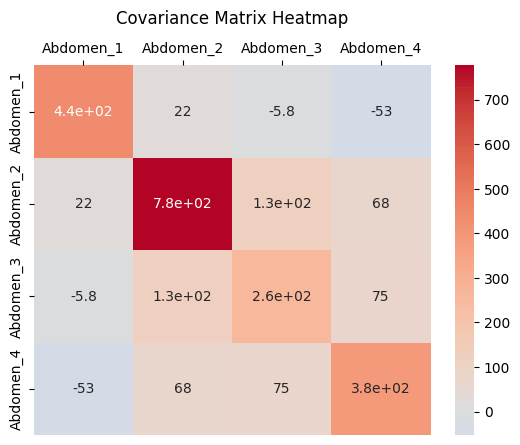

In [8]:
abd_signal_mean = np.mean(abdomen_signals, axis=1, keepdims=True)
center_flag = not np.allclose(abd_signal_mean, np.zeros((abdomen_signals.shape[0],1)),
                                 atol=1e-5)

# Mean array is transposed for clearer reading.
print(f"The mean value of each abdomen channel is:", abd_signal_mean.T)
print("Signals need centering:", center_flag)
print()

cov_mat = np.cov(abdomen_signals)
identity = np.eye(cov_mat.shape[0])
deviation_flag = not np.allclose(cov_mat, identity, atol=1e-5)
error = np.linalg.norm(cov_mat - identity)

print("Covariance Matrix:")
print(np.round(cov_mat,3))
print()

print(f"Deviation from Identity (Frobenius norm): {error:.3f}")
print("Data needs whitening:", deviation_flag)
print()

cov_heat = sns.heatmap(cov_mat, annot=True, cmap='coolwarm',center=0,
            xticklabels=signal_labels[1:], yticklabels=signal_labels[1:])

cov_heat.xaxis.set_ticks_position('top')
cov_heat.xaxis.set_label_position('top')
cov_heat.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.title("Covariance Matrix Heatmap", pad=30)
plt.show()

2) Perform ICA over the abdomen signals. Whitening is applied before ICA, if necessary. Print details of ICA input X, output S and demixing matrix W.

In [9]:
if (deviation_flag or center_flag):
  ica = FastICA(n_components = 4,
                whiten = 'unit-variance',
                fun = 'logcosh',
                fun_args = {'alpha': 1.0},
                algorithm='deflation',
                random_state = 1,
                )
else:
  ica = FastICA(n_components = 4,
                whiten = False,
                fun = 'logcosh',
                fun_args = {'alpha': 1.0},
                algorithm='deflation',
                random_state = 1,
                )

S = (ica.fit_transform(abdomen_signals.T)).T
W = ica.components_

ica_components = S

print("---------- ICA Application ----------")
print()
print("Input X: ECG abdomen_signals")
print("Shape: (Num of channels, Num of samples over time) = ", abdomen_signals.shape)
print()
print("Output S: ica_components")
print("Shape: (Num of Components, Num of values over time) = ", ica_components.shape)
print()
print("Demixing Matrix W:\n", W)
print("Shape: (Num of Components, Num of channels) =", W.shape)
print()


# # Two ICA applications compared

# ica2 = FastICA(n_components=2, # or 3 for noise
#                 whiten='arbitrary-variance',
#                 fun='logcosh', # or 'exp' because of spikes
#                 fun_args={'alpha': 1.0}, # or >1.2 because is probs better for spikes
#                 random_state=1,
#                 )

# S2 = (ica2.fit_transform(abdomen_signals.T)).T
# W2 = ica2.components_

# ica_components2 = S2

# print("---------- ICA Application 2 ----------")
# print()
# print("Input X: ECG abdomen_signals")
# print("Shape: (Num of channels, Num of samples over time) = ", abdomen_signals.shape)
# print()
# print("Output S: ica_components")
# print("Shape: (Num of Components, Num of values over time) = ", ica_components2.shape)
# print()
# print("Demixing Matrix W:\n", W)
# print("Shape: (Num of Components, Num of channels) =", W2.shape)
# print()

---------- ICA Application ----------

Input X: ECG abdomen_signals
Shape: (Num of channels, Num of samples over time) =  (4, 300000)

Output S: ica_components
Shape: (Num of Components, Num of values over time) =  (4, 300000)

Demixing Matrix W:
 [[-1.81355034e-02  1.38750089e-02  4.57399791e-02 -2.88760451e-02]
 [ 3.50428661e-02 -8.64404045e-03  1.58085073e-02 -2.88818184e-02]
 [ 1.36217729e-02  3.37627991e-02 -3.41175592e-02  4.11722229e-04]
 [ 2.41178442e-02  1.27518356e-05  3.07565561e-02  3.39408894e-02]]
Shape: (Num of Components, Num of channels) = (4, 4)



3) Plot the sources/components S over time.

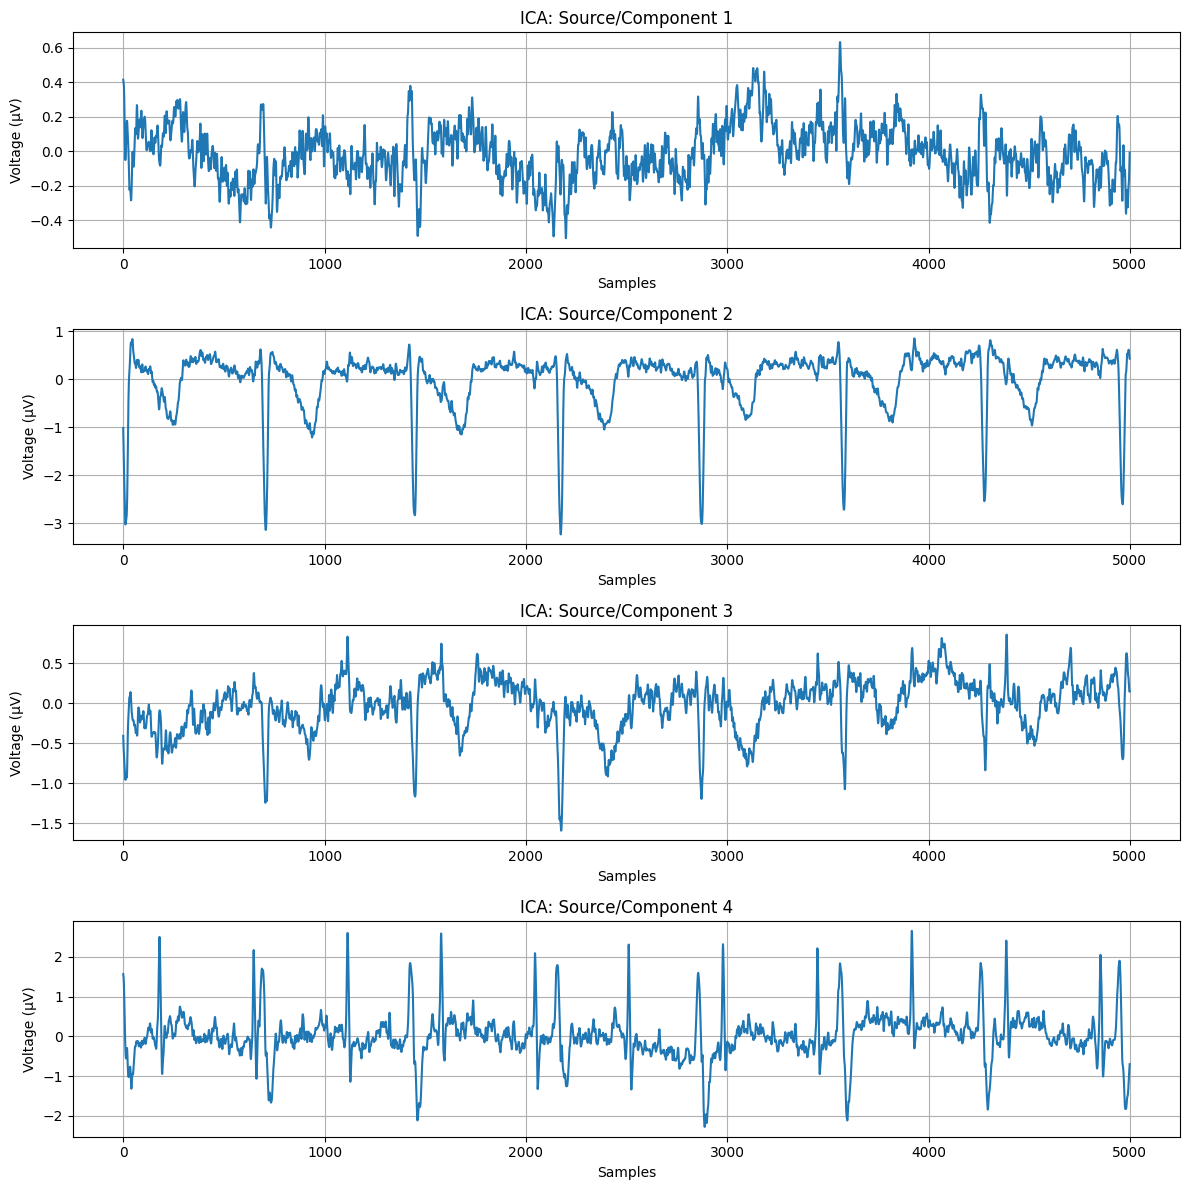

In [10]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 5      # Each signal lasts 300sec.
# ----------------------

end_time = start_time + duration

start_time = np.clip(start_time, 0, 300)
end_time = np.clip(end_time, 0, 300)

# ex. For duration = 3000 sec, 300 * fs = 300 * 1000 = 300000 samples.
cropped_signals = S[:, int(start_time * fs):int(end_time * fs)]
source_num = cropped_signals.shape[0]
plt.figure(figsize=(12, 3 * source_num))
for i in range(source_num):
    plt.subplot(source_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'ICA: Source/Component {i+1}')
    plt.xlabel('Samples')
    plt.ylabel('Voltage (μV)')
    plt.grid()

plt.tight_layout()
plt.show()

# cropped_signals = S2[:, start_time * int(fs):(start_time + duration) * int(fs)]
# source_num = cropped_signals.shape[0]
# plt.figure(figsize=(12, 3 * source_num))
# for i in range(source_num):
#     plt.subplot(source_num, 1, i + 1)
#     plt.plot(cropped_signals[i,:])
#     plt.title(f'ICA: Component {i+1}')
#     plt.xlabel('Samples')
#     plt.ylabel('Voltage (μV)')

# plt.tight_layout()
# plt.grid()
# plt.show()

## **Part 3**: Maternal vs. Fetal ECG Identification

In this part it is defined which signal corresponds to the mother and which to the fetus. The classification is achieved through the extraction of the heart beat frequency of each Source. The one with higher frequency is matched to the Fetus and the lower to the Mother. To identify the Heart Rates, three different methods are utilized and compared:

1.   Fast Fourier Transform (FFT)
2.   Autocorrelation
3.   Wavelets






### **Part 3.1**: Fast Fourier Transform (FFT)

---------- ICA Component 1 Classification ----------

First 10 maternal_rr: [0.73  0.736 0.713 1.081 0.775 0.746 0.727 0.769 1.191 0.768]
Density of maternal peaks: 0.001307
Standard Deviation of maternal_rr: 0.144

First 10 fetal_rr: [0.694 0.73  0.736 0.693 0.713 0.699 0.677 0.677 0.574 0.712]
Density of fetal peaks: 0.001857
Standard Deviation of fetal_rr: 0.135

Component 1: Maternal | HR: 70.23 bpm | Dom Freq: 0.42 Hz



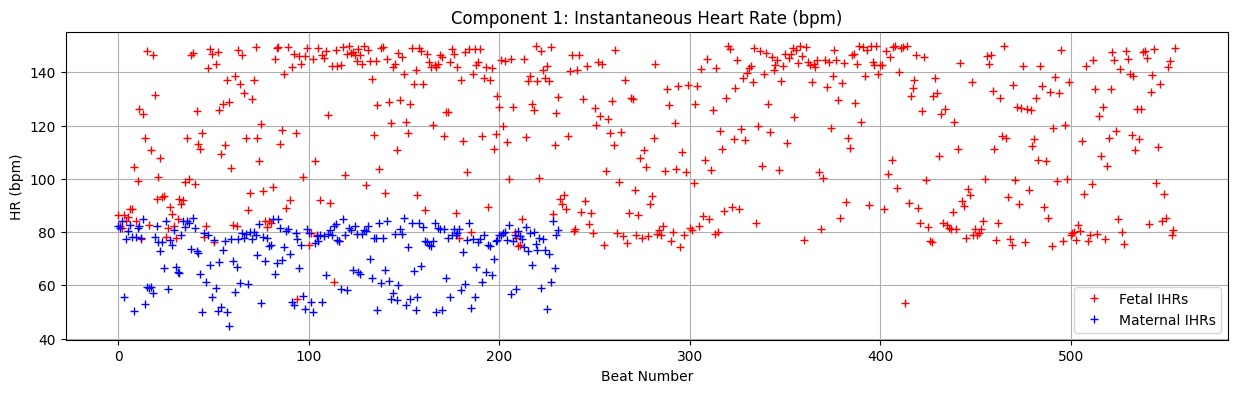

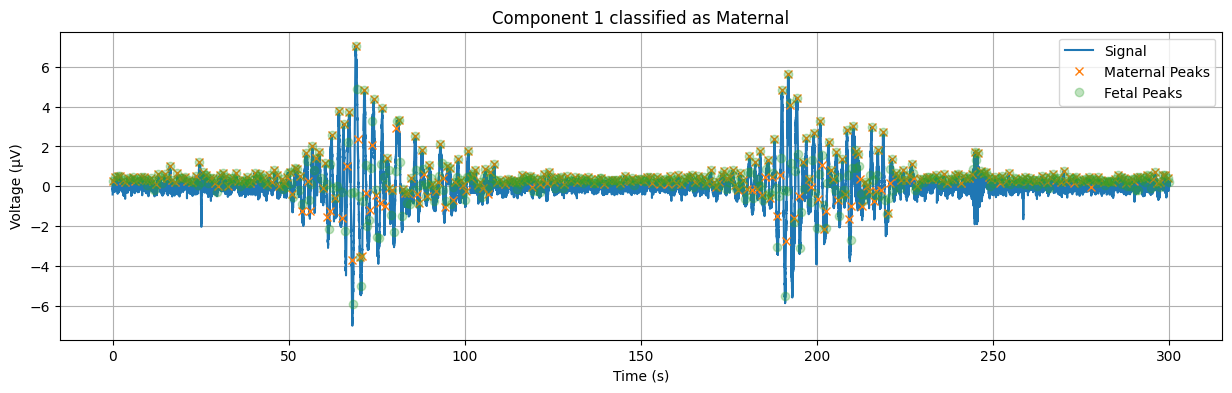


---------- ICA Component 2 Classification ----------

First 10 maternal_rr: [0.74  0.725 0.707 0.749 0.73  0.72  1.232 0.759 0.733 0.728]
Density of maternal peaks: 0.001367
Standard Deviation of maternal_rr: 0.056

First 10 fetal_rr: [0.697 0.74  0.725 0.7   0.707 0.697 0.687 0.679 0.654 0.614]
Density of fetal peaks: 0.001433
Standard Deviation of fetal_rr: 0.096

Component 2: Maternal | HR: 79.11 bpm | Dom Freq: 0.38 Hz



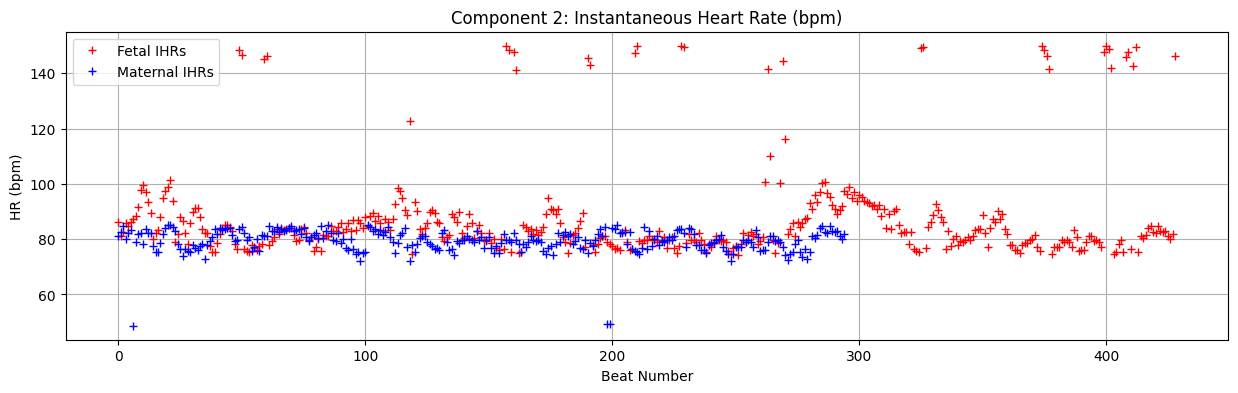

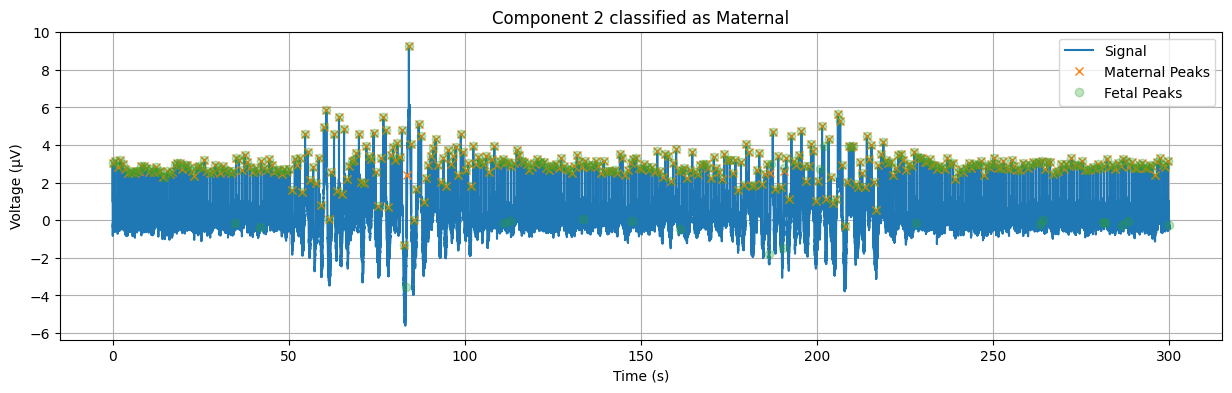


---------- ICA Component 3 Classification ----------

First 10 maternal_rr: [0.744 0.725 0.712 0.991 1.198 0.754 0.738 0.733 0.759 0.701]
Density of maternal peaks: 0.001343
Standard Deviation of maternal_rr: 0.096

First 10 fetal_rr: [0.695 0.744 0.725 0.697 0.712 0.698 0.682 0.678 0.658 0.61 ]
Density of fetal peaks: 0.001627
Standard Deviation of fetal_rr: 0.139

Component 3: Maternal | HR: 76.62 bpm | Dom Freq: 0.33 Hz



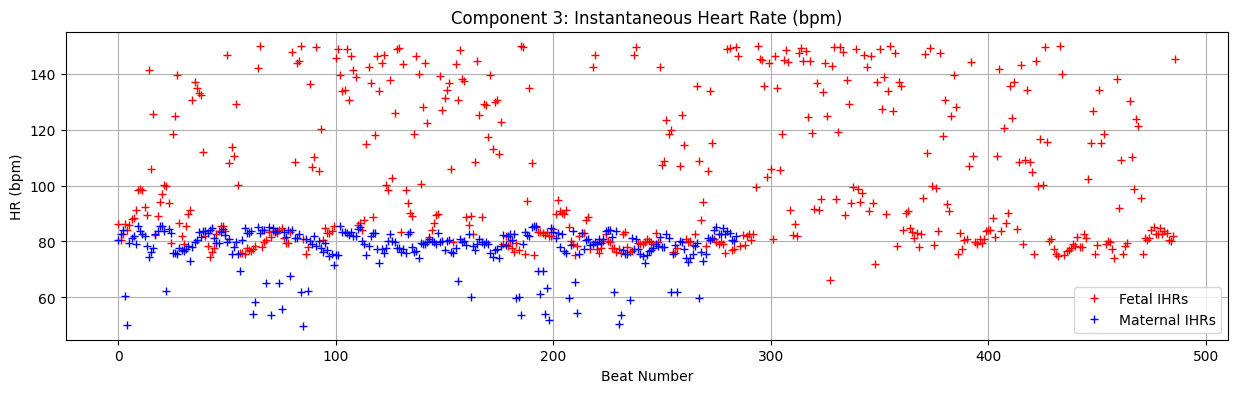

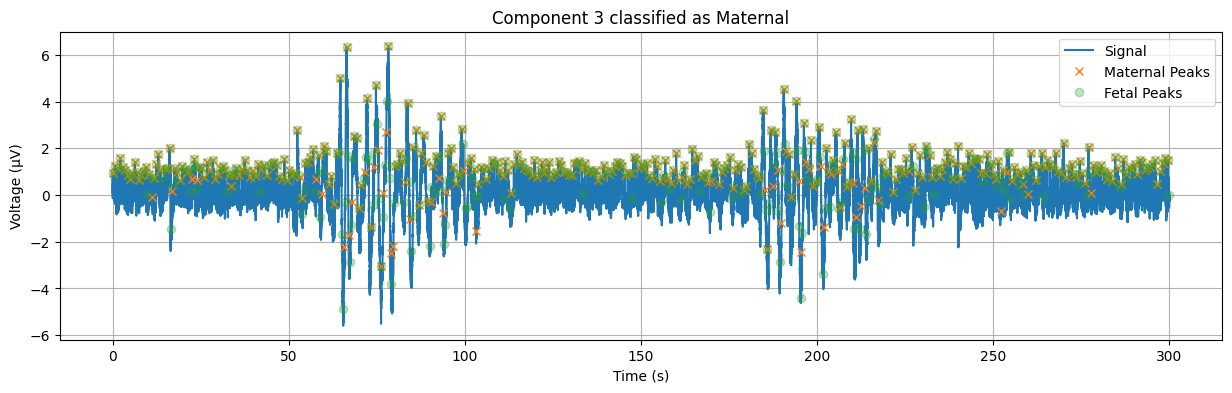


---------- ICA Component 4 Classification ----------

First 10 maternal_rr: [0.934 0.931 0.934 0.938 0.937 0.939 0.773 0.938 0.931 0.758]
Density of maternal peaks: 0.001257
Standard Deviation of maternal_rr: 0.109

First 10 fetal_rr: [0.468 0.466 0.465 0.466 0.466 0.468 0.469 0.469 0.469 0.468]
Density of fetal peaks: 0.002063
Standard Deviation of fetal_rr: 0.072

Component 4: Maternal | HR: 68.50 bpm | Dom Freq: 0.44 Hz



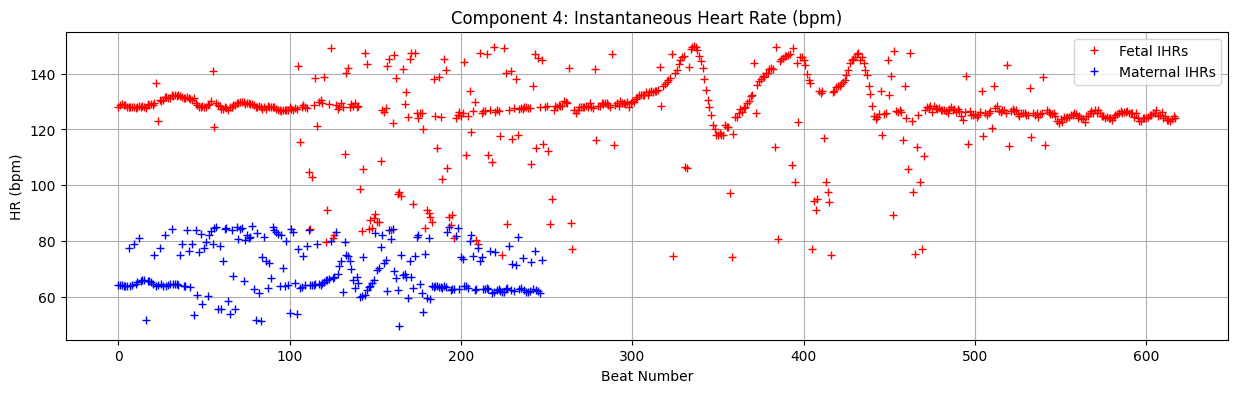

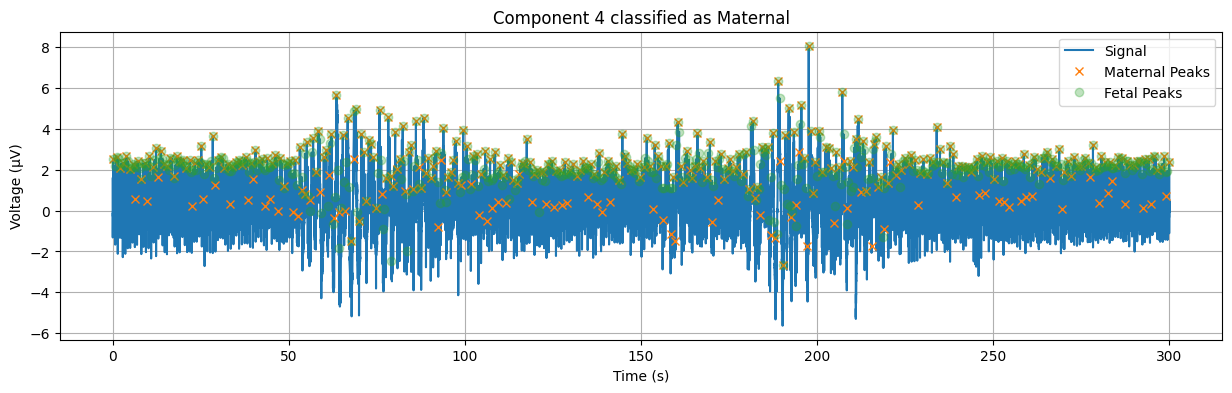

In [15]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 300      # Each signal lasts 300sec.
# ----------------------

# ex. For duration = 3000 sec, 300 * fs = 300 * 1000 = 300000 samples.
start_samp = int(start_time * fs)
fin_samp = int((start_time + duration) * fs)

start_samp = int(np.clip(start_samp, 0, 300 * fs))
fin_samp = int(np.clip(fin_samp, 0, 300 * fs))

fetal_or_noise_signal = []

for i in range(ica_components.shape[0]):

    signal = ica_components[i, start_samp:fin_samp]
    min_rr_count = int((fin_samp - start_samp) / (fs * 10))

    if np.max(-signal) > np.max(signal):
        signal = -signal

    maternal_peaks, _ = find_peaks(signal, distance=int(0.6 * fs), prominence=0.006)
    if len(maternal_peaks) > 1:
        maternal_rr = np.diff(maternal_peaks) / fs
        maternal_rr = maternal_rr[maternal_rr > 0.7]
        hr_maternal = 60 / np.mean(maternal_rr) if maternal_rr.size > min_rr_count else np.nan
    else:
        hr_maternal = np.nan

    density_maternal = len(maternal_peaks) / int(duration * fs)
    consistency_maternal = np.std(maternal_rr)

    fetal_peaks, _ = find_peaks(signal, distance=int(min_rr * fs), prominence=0.006)
    ground_truth_rr = np.mean(rr_intervals) / fs
    if len(fetal_peaks) > 1:
        fetal_rr = np.diff(fetal_peaks) / fs
        # fetal_rr = fetal_rr[(fetal_rr > ground_truth_rr-0.05) & (fetal_rr < ground_truth_rr+0.05)]  # filter
        hr_fetal = 60 / np.mean(fetal_rr) if fetal_rr.size > min_rr_count else np.nan
    else:
        hr_fetal = np.nan

    density_fetal = len(fetal_peaks) / int(duration * fs)
    consistency_fetal = np.std(fetal_rr)


    print(f"---------- ICA Component {i+1} Classification ----------\n")

    print(f"First 10 maternal_rr: {maternal_rr[:10]}")
    print(f"Density of maternal peaks: {density_maternal:.6f}")
    print(f"Standard Deviation of maternal_rr: {consistency_maternal:.3f}\n")

    print(f"First 10 fetal_rr: {fetal_rr[:10]}")
    print(f"Density of fetal peaks: {density_fetal:.6f}")
    print(f"Standard Deviation of fetal_rr: {consistency_fetal:.3f}\n")


    yf = np.abs(np.fft.rfft(signal))
    xf = np.fft.rfftfreq(signal.shape[0], 1 / fs)
    mask = (xf > 0.1) & (xf < 5)
    dominant_freq = xf[mask][np.argmax(yf[mask])]

    maternal_ihr_bpm = 60 / maternal_rr if len(maternal_rr) else np.array([])
    maternal_ihr_hz = maternal_ihr_bpm / 60
    fetal_ihr_bpm = 60 / fetal_rr if len(fetal_rr) else np.array([])
    fetal_ihr_hz = fetal_ihr_bpm / 60

    if (np.abs(np.mean(fetal_ihr_bpm) - np.mean(maternal_ihr_bpm)) > 10) and (fetal_rr[0] > 20):
        label, hr = "Fetal or Noise", hr_fetal
        fetal_or_noise_signal.append(signal)
    else:
        label, hr = "Maternal", hr_maternal

    print(f"Component {i+1}: {label} | HR: {hr:.2f} bpm | Dom Freq: {dominant_freq:.2f} Hz\n")

    plt.figure(figsize=(15, 4))
    plt.plot(fetal_ihr_bpm, "r+", label="Fetal IHRs")
    plt.plot(maternal_ihr_bpm, "b+", label="Maternal IHRs")
    plt.title(f"Component {i+1}: Instantaneous Heart Rate (bpm)")
    plt.xlabel("Beat Number")
    plt.ylabel("HR (bpm)")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot signal + peaks
    time_window = np.arange(start_samp, fin_samp) / fs
    plt.figure(figsize=(15, 4))
    plt.plot(time_window, signal, label="Signal")
    plt.plot(time_window[maternal_peaks], signal[maternal_peaks], "x", label="Maternal Peaks")
    plt.plot(time_window[fetal_peaks], signal[fetal_peaks], "o", label="Fetal Peaks", alpha=0.3)
    plt.title(f"Component {i+1} classified as {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (μV)")
    plt.legend()
    plt.grid()
    plt.show()
    print()

fetal_rr: [0.693 0.729 0.737 0.693 0.705 0.707 0.677 0.677 0.515 0.757]
maternal_rr: [0.693 0.729 0.737 0.693 0.705 0.707 0.677 0.677 0.659 0.613]
Component 0: Fetal or Noise | HR: 104.62 bpm | Dom Freq: 0.42333333333333334 Hz


<ipython-input-11-e0e06ae8c58b>:34: RuntimeWarning: divide by zero encountered in divide
  density_fetal = len(fetal_peaks) / time
<ipython-input-11-e0e06ae8c58b>:35: RuntimeWarning: divide by zero encountered in divide
  density_maternal = len(maternal_peaks) / time


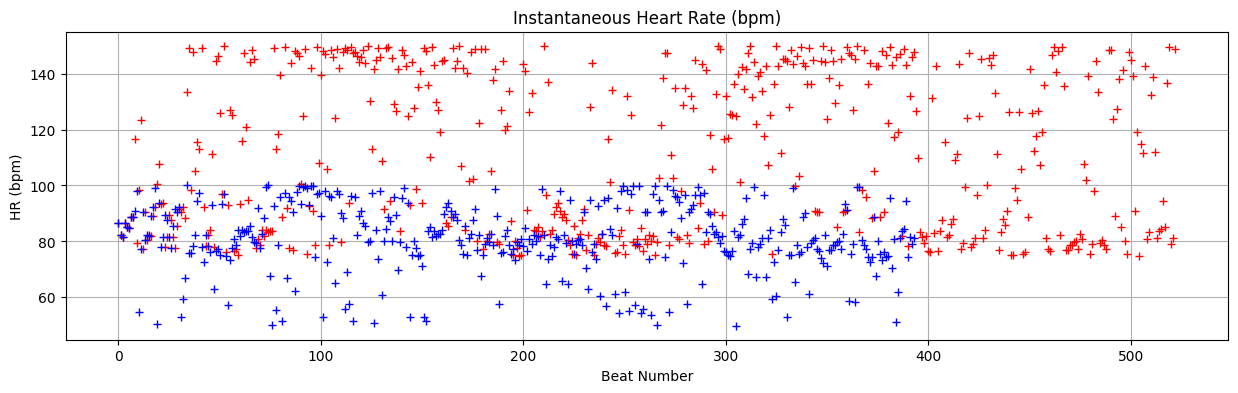

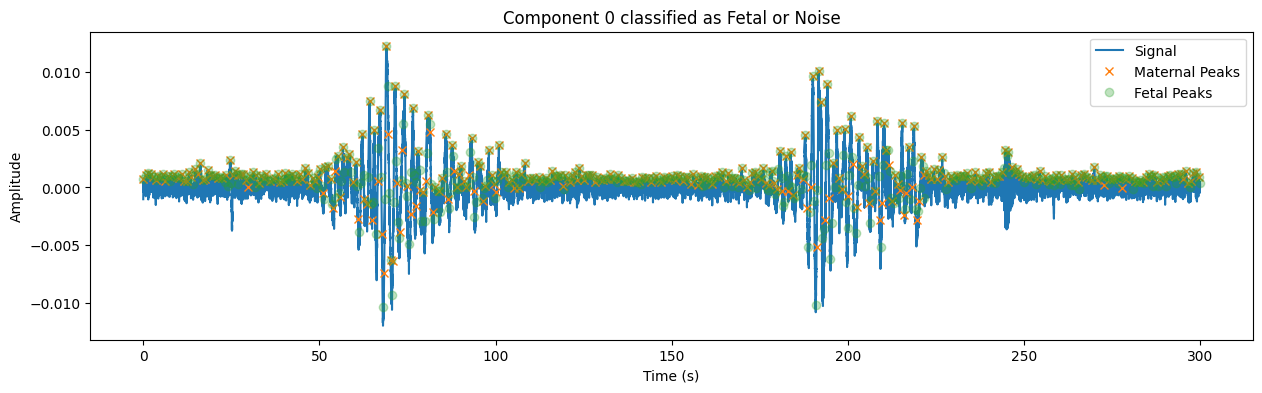

fetal_rr: [0.697 0.74  0.725 0.7   0.707 0.698 0.686 0.679 0.654 0.614]
maternal_rr: [0.697 0.74  0.725 0.7   0.707 0.698 0.686 0.679 0.654 0.614]
Component 1: Maternal | HR: 81.93 bpm | Dom Freq: 0.38333333333333336 Hz


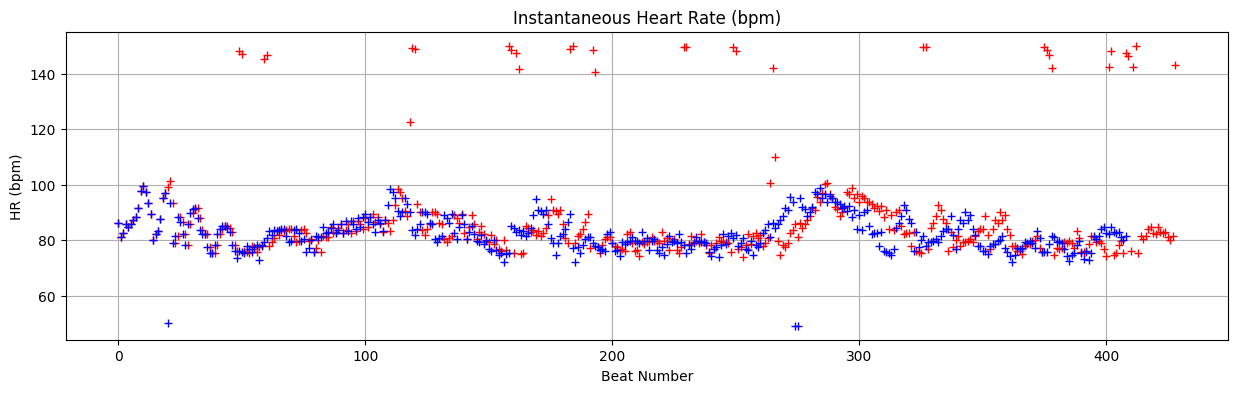

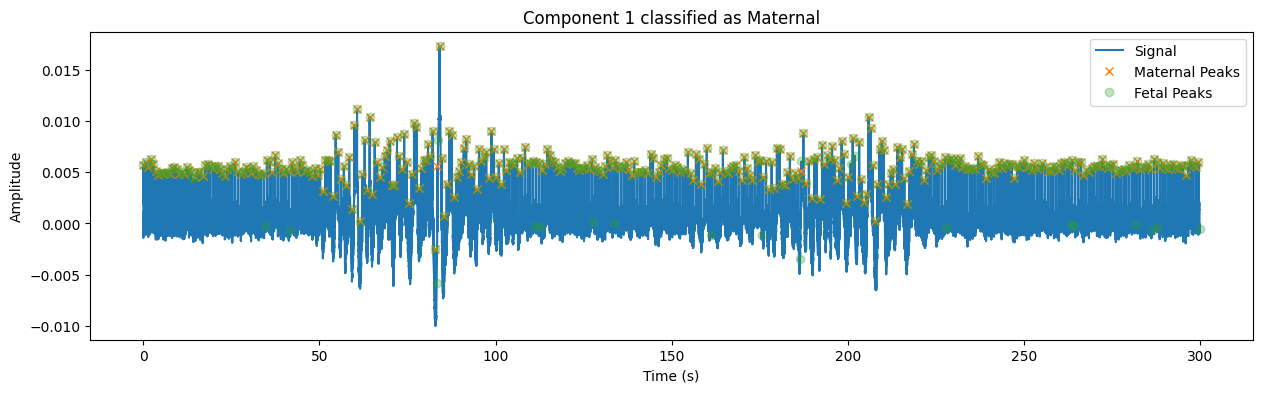

fetal_rr: [0.468 0.466 0.465 0.466 0.466 0.468 0.469 0.469 0.469 0.468]
maternal_rr: [0.934 0.624 0.773 0.632 0.774 0.937 0.939 0.63  0.773 0.938]
Component 2: Fetal or Noise | HR: 122.91 bpm | Dom Freq: 0.4166666666666667 Hz


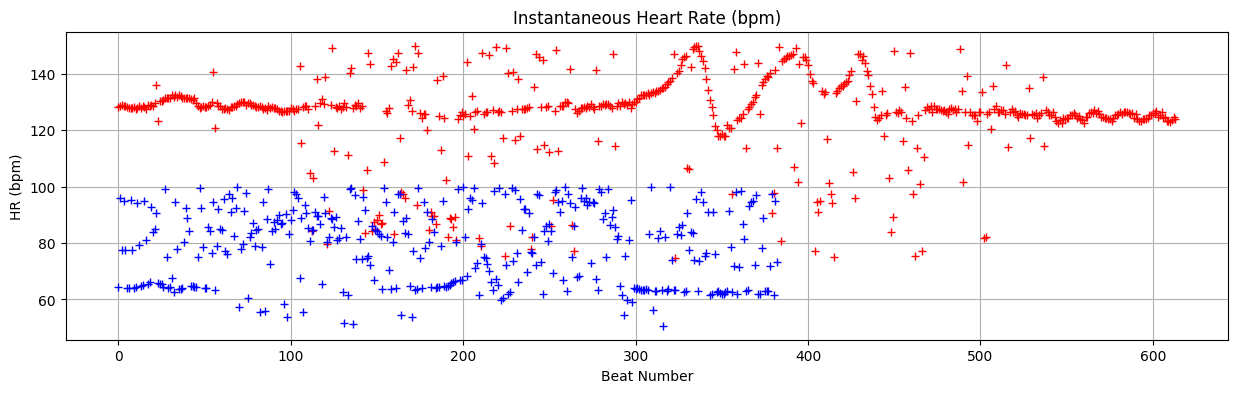

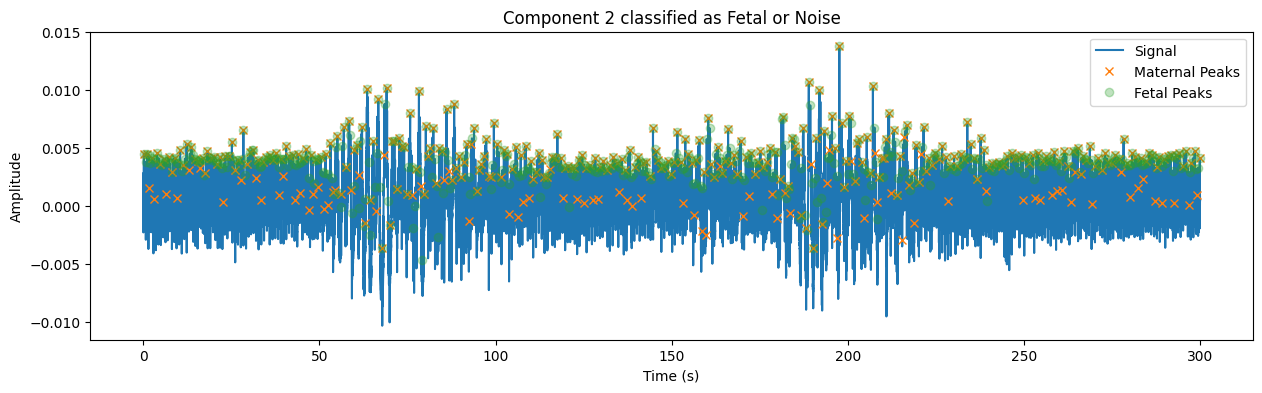

fetal_rr: [0.52  0.739 0.722 0.697 0.714 0.696 0.486 0.433 0.652 0.447]
maternal_rr: [0.608 0.651 0.722 0.697 0.714 0.696 0.686 0.682 0.65  0.611]
Component 3: Fetal or Noise | HR: 111.68 bpm | Dom Freq: 0.3766666666666667 Hz


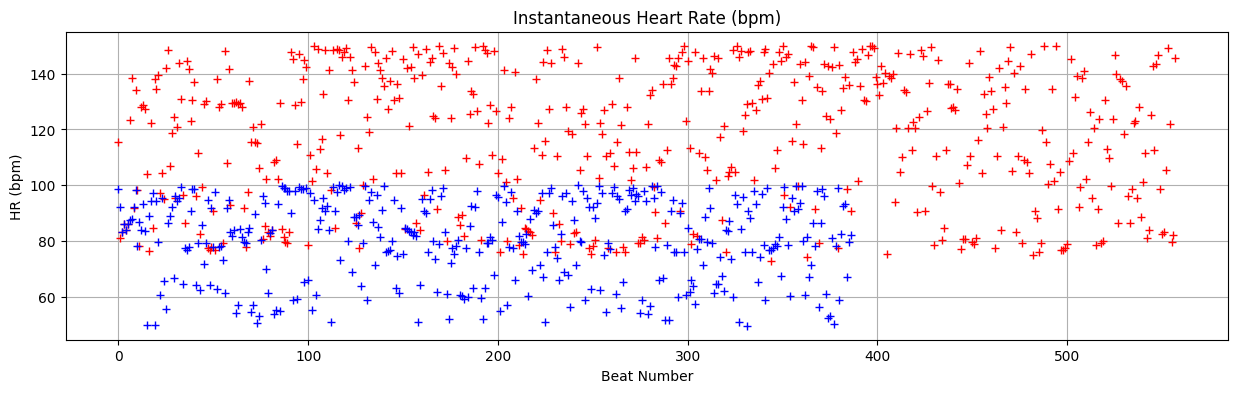

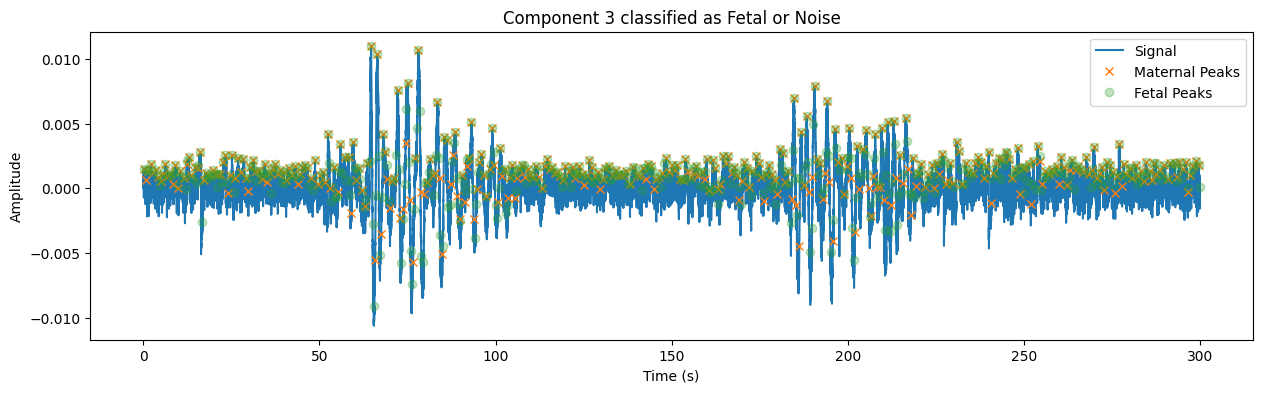

In [ ]:
time = np.arange(ica_components.shape[1]) / fs

fetal_or_noise_signal = []

for i in range(ica_components.shape[0]):
    duration_sec = 20 * fs
    signal = ica_components[i, :]

    # Flip if average peak in -signal is stronger
    if np.max(-signal) > np.max(signal):
        signal = -signal

    # Maternal peaks
    maternal_peaks, maternal_props = find_peaks(signal, distance=int(0.6*fs))

    if len(maternal_peaks) > 1:
        maternal_rr = np.diff(maternal_peaks) / fs
        hr_maternal = 60 / np.mean(maternal_rr)
    else:
        hr_maternal = np.nan

    # Fetal peaks
    fetal_peaks, fetal_props = find_peaks(signal, distance=int(min_rr*fs))

    if len(fetal_peaks) > 1:
        fetal_rr = np.diff(fetal_peaks) / fs # min_rr
        hr_fetal = 60 / np.mean(fetal_rr)
    else:
        hr_fetal = np.nan


    print(f"fetal_rr: {fetal_rr[:10]}")
    print(f"maternal_rr: {maternal_rr[:10]}")

    density_fetal = len(fetal_peaks) / time
    density_maternal = len(maternal_peaks) / time

    consistency_fetal = np.std(fetal_rr)
    consistency_maternal = np.std(maternal_rr)

    # Frequency domain analysis
    yf = np.abs(np.fft.rfft(signal))
    xf = np.fft.rfftfreq(signal.shape[0], 1 / fs)

    # Limit to cardiac-relevant band (0.5–5 Hz)
    mask = (xf > 0.1) & (xf < 5)
    dominant_freq = xf[mask][np.argmax(yf[mask])]

    fetal_ihr_hz = 1 / fetal_rr
    fetal_ihr_bpm = 60 / fetal_rr
    maternal_ihr_hz = 1 / maternal_rr
    maternal_ihr_bpm = 60 / maternal_rr

    if np.abs(np.mean(fetal_ihr_bpm) - np.mean(maternal_ihr_bpm)) > 10:
        label, hr = "Fetal or Noise", hr_fetal
        fetal_or_noise_signal.append(signal)
    else:
        label, hr = "Maternal", hr_maternal
    print(f"Component {i}: {label} | HR: {hr:.2f} bpm | Dom Freq: {dominant_freq} Hz")

    plt.figure(figsize=(15, 4))
    plt.plot(fetal_ihr_bpm, "r+", label="Fetal IHRs")
    plt.plot(maternal_ihr_bpm, "b+", label="Maternal IHRs")
    plt.title("Instantaneous Heart Rate (bpm)")
    plt.xlabel("Beat Number")
    plt.ylabel("HR (bpm)")
    plt.grid()
    plt.show()


    # Main plot:
    plt.figure(figsize=(15, 4))
    plt.plot(time[:], signal, label="Signal")
    plt.plot(time[maternal_peaks], signal[maternal_peaks], "x", label="Maternal Peaks")
    plt.plot(time[fetal_peaks], signal[fetal_peaks], "o", label="Fetal Peaks", alpha=0.3)
    plt.title(f"Component {i} classified as {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

### **Part 3.2**: Autocorrelation

### **Part 3.3**: Wavelets

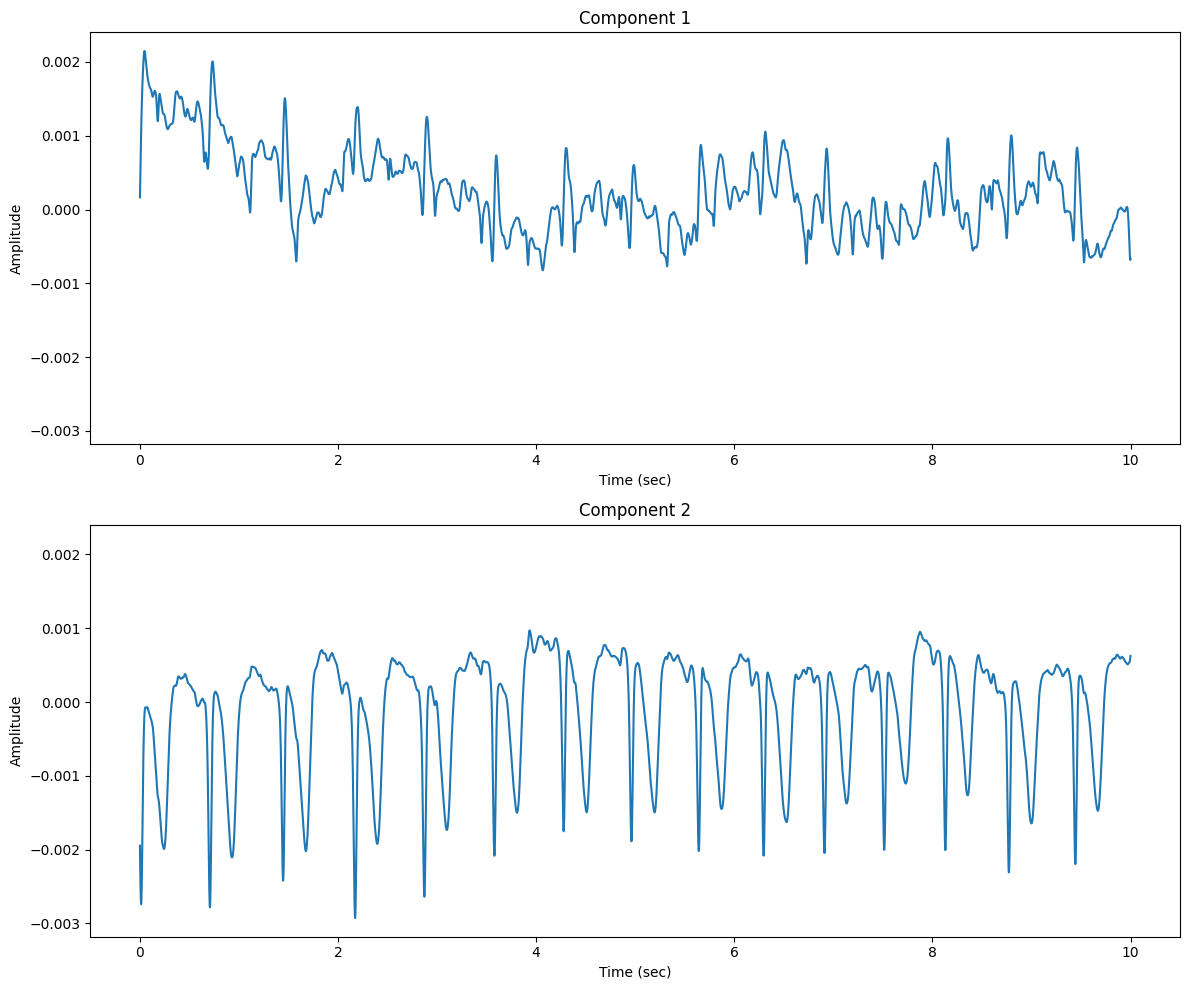

In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs  # συχνότητα Nyquists
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[0]):
    filtered_signals[i, :] = bandpass_filter(
        data=ica_components[i, :],
        lowcut= 0.1,
        highcut=10,
        fs=fs,
    )

fig, axes = plt.subplots(filtered_signals.shape[0], 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time[:10000], filtered_signals[i, :10000])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

ica_components.shape: (2, 300000)
ica_components[0].shape (first row): (300000,)


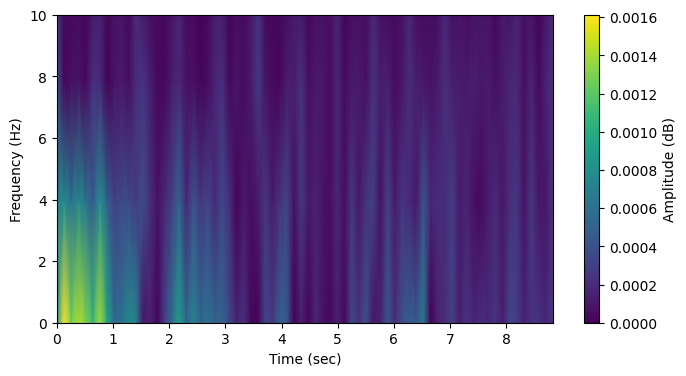

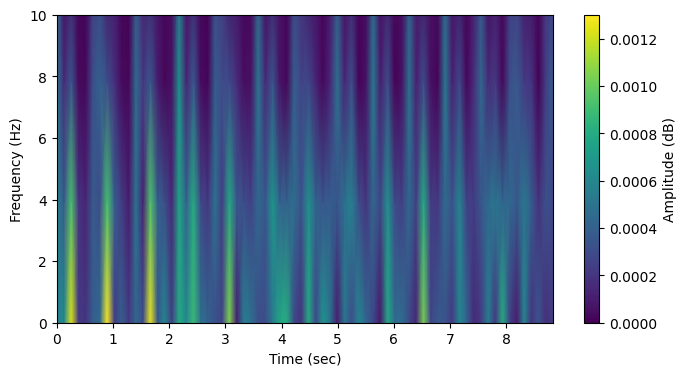

In [ ]:
print("ica_components.shape:", ica_components.shape)
print("ica_components[0].shape (first row):", ica_components[1].shape)

time_limit = 70
for i in range(filtered_signals.shape[0]):
  # Compute the STFT on the selected component
  f, t, Zxx = stft(filtered_signals[i, :], fs=fs, nperseg=256)

  # print("Shape of f:", f.shape)
  # print("Shape of t:", t.shape)
  # print("Shape of Zxx:", Zxx.shape)

  # Plot the spectrogram
  plt.figure(figsize=(8, 4))
  plt.pcolormesh(t[:time_limit], f, np.abs(Zxx[:, :time_limit]), shading='gouraud')
  plt.ylabel("Frequency (Hz)")
  plt.xlabel("Time (sec)")
  plt.colorbar(label="Amplitude (dB)")
  plt.ylim([0, 10])
  plt.show()

In [ ]:
!pip install PyWavelets
import pywt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.4 MB/s eta 0:00:00


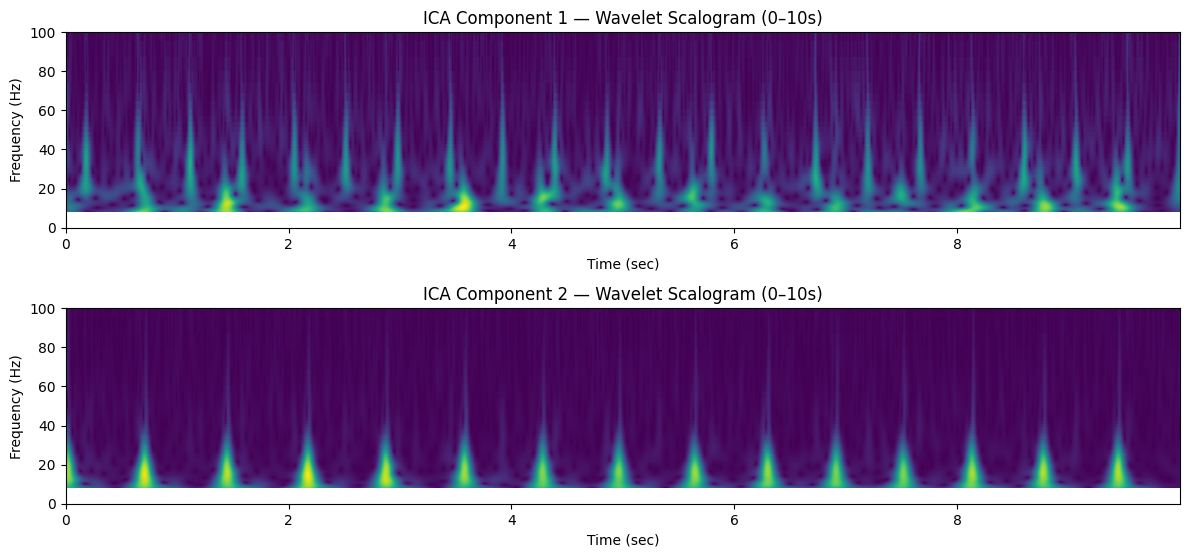

In [ ]:
end_idx = int(10 * fs)
time_limit = time[:end_idx]
time = np.arange(ica_components.shape[1]) / fs

wavelet = 'cmor1.5-1.0'         # complex Morlet
scales = np.arange(1, 128)      # max scale for resolution

plt.figure(figsize=(12, 8))
for i in range(ica_components.shape[0]):
    sig10 = ica_components[i, :end_idx]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()

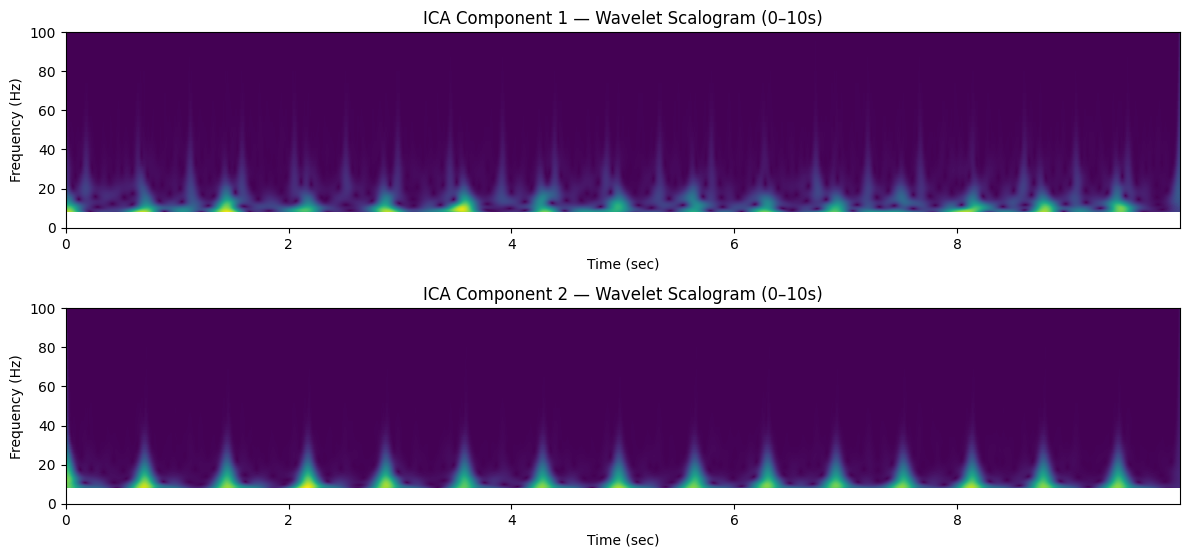

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(filtered_signals.shape[0]):
    sig10 = filtered_signals[i, :end_idx]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()